# llc4320 drifters spectra: Lagrangian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from cmocean import cm
import dask.dataframe as dd
from xhistogram.xarray import histogram
import xskillscore as xs

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.6354793.datarmor0/parcels-502027/libparcels_random_de30c46c-ad97-4a1b-8068-0b90f95203fd.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster() # necessary?
    #w = cluster.scale(jobs=15)
    w = cluster.scale(jobs=1)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.1.66:37340 Dashboard: http://10.148.1.66:8787/status,Cluster Workers: 7 Cores: 7 Memory: 111.79 GiB


---
# Lagrangian spectra

## 1. lat x lon binning (i.e. 2D)

In [4]:
# load Lagrangian data
# The 'global_T365j_dt1j_dij50' data do not work

root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50_XCYC'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])

In [ ]:
# This works for 2*2 bins

# bin size
dl = 2
# water depth lower bound
depth = 500

###### north ######
# read raw Lagrangian spectra
df = p.load_diagnostic('spectra_uv_T60_mean0')
df.head()

# add bathymetry to dataframe
def interp_bathy(df):
    bathy = ut.load_bathy(15)
    ds = df[['lon','lat']].to_xarray()
    ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
    df_interpolated = ds_interpolated.to_dataframe()[bathy.name]
    return df.assign(**{bathy.name: df_interpolated})
df = df.map_partitions(interp_bathy)

# filter out depth ranges
df = df[df['h']>depth]
df.head()

# bin geographically
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-1, 63, dl)
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, bins=lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)
df = df.reset_index().persist()
E = df.groupby(['lon_cut', 'lat_cut']).agg(['mean', 'count']).compute()

#Converting pandas dataframe in xarray dataset:
index = pd.MultiIndex.from_arrays([E.index.map(lambda v: v[0].mid),
                                   E.index.map(lambda v: v[1].mid)
                                  ], 
                                  names=('lon_cut', 'lat_cut'),
                                 )
ds = (pd.melt(E.set_index(index)
              .drop(columns=['time','lon','lat', 'h', 'trajectory'])
              .reset_index(), id_vars=['lon_cut', 'lat_cut',],
              #var_name='frequency',
             )
      .rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'E'})
     ).to_xarray().set_index(index=['lon_bins', 'lat_bins']).unstack()
ds = ds.drop(['variable_0','variable_1'])
ds_north = ds
print(ds)

# read raw Lagrangian spectra
df = p.load_diagnostic('spectra_uv_T60_mean0')
df.head()

# add bathymetry to dataframe
def interp_bathy(df):
    bathy = ut.load_bathy(15)
    ds = df[['lon','lat']].to_xarray()
    ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
    df_interpolated = ds_interpolated.to_dataframe()[bathy.name]
    return df.assign(**{bathy.name: df_interpolated})
df = df.map_partitions(interp_bathy)

# filter out depth ranges
df = df[df['h']>depth]
df.head()

# bin geographically
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-61, 3, dl)    
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, bins=lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)
df = df.reset_index().persist()
E = df.groupby(['lon_cut', 'lat_cut']).agg(['mean', 'count']).compute()

#Converting pandas dataframe in xarray dataset:
index = pd.MultiIndex.from_arrays([E.index.map(lambda v: v[0].mid),
                                   E.index.map(lambda v: v[1].mid)
                                  ], 
                                  names=('lon_cut', 'lat_cut'),
                                 )
ds = (pd.melt(E.set_index(index)
              .drop(columns=['time','lon','lat', 'h', 'trajectory'])
              .reset_index(), id_vars=['lon_cut', 'lat_cut',],
              #var_name='frequency',
             )
      .rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'E'})
     ).to_xarray().set_index(index=['lon_bins', 'lat_bins']).unstack()
ds = ds.drop(['variable_0','variable_1'])
ds_south = ds   
print(ds)

# together
ds_all = xr.concat([ds_south, ds_north.where(ds_north.lat_bins>0,drop=True)], dim="lat_bins")

# store diagnostic
p.store_diagnostic('Lagrangian_weight_lat_lon_2deg', ds_all, overwrite=True)

# Account for Lagrangian weights

In [5]:
# load spectra
ds_c = p.load_diagnostic('Lagrangian_weight_lat_lon_2deg.zarr')
ds_c = ds_c.E.where(ds_c.E>0)
ds_c

<xarray.DataArray 'E' (lon_bins: 179, lat_bins: 61)>
dask.array<where, shape=(179, 61), dtype=float64, chunksize=(179, 61), chunktype=numpy.ndarray>
Coordinates:
  * lat_bins  (lat_bins) float64 -60.0 -58.0 -56.0 -54.0 ... 54.0 56.0 58.0 60.0
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0

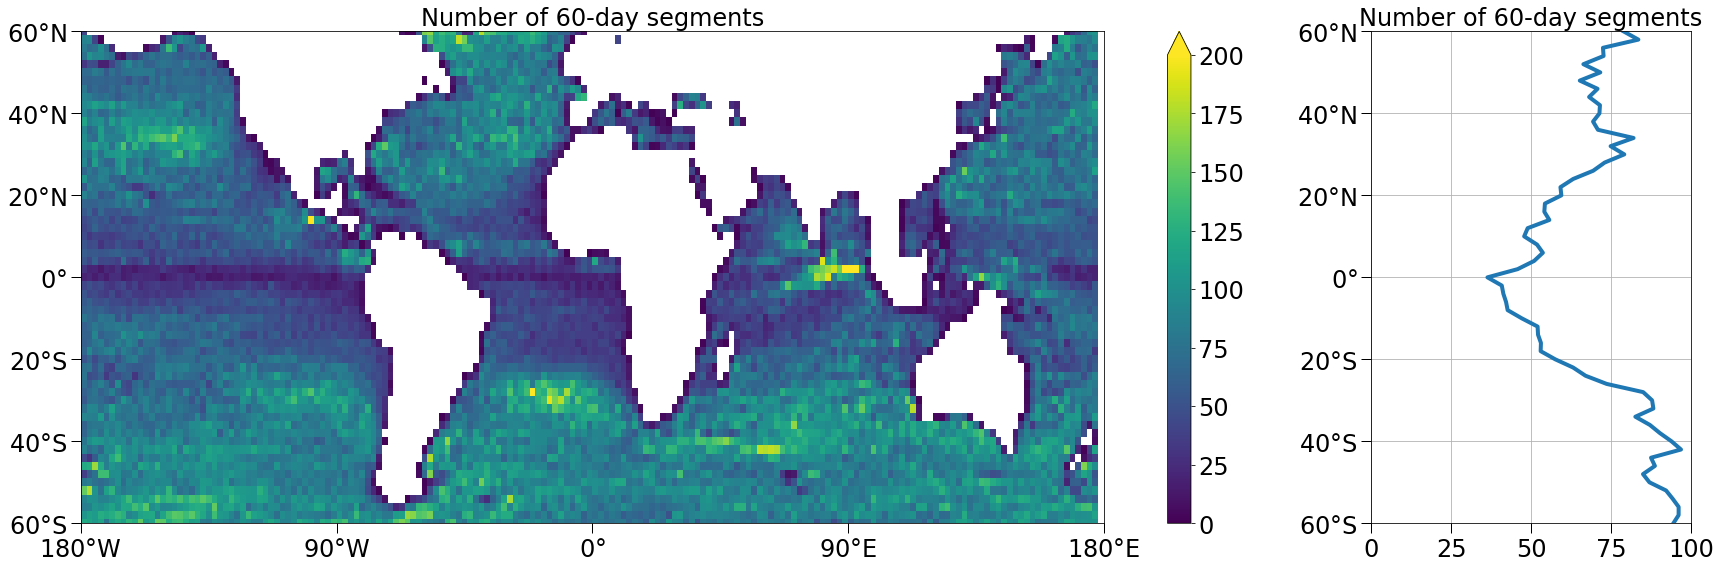

In [35]:
# load spectra
font_size = 24

fig, ax = plt.subplots(figsize=(24,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 
ax = plt.subplot(gs[0])
cax = ds_c.plot(x='lon_bins',cmap='viridis',vmin=0,vmax=200, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='max', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Number of 60-day segments',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(gs[1])
ds_c.mean('lon_bins').plot(y='lat_bins',linewidth=4)
ax.set_xlim(0., 100.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Number of 60-day segments',fontsize=font_size)

plt.tight_layout()
plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Segment_distribution.png')

## Comparison

In [6]:
# load raw spectra (zonally averaged)
ds_L = (p.load_diagnostic('spectra_uv_T60_mean0_lat.zarr')
        .rename({'E':'E_Lagrangian'})
       )

ds_E = (xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat.zarr'))
        .rename({'E_SSUV_T60': 'E_Eulerian'})
       )

ds = xr.merge([ds_L, ds_E])

E_Lagrangian = ds.E_Lagrangian
E_Eulerian = ds.E_Eulerian
df=E_Eulerian.frequency[1]-E_Eulerian.frequency[0]
# Inertial frequency
f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_Eulerian.lat_bins))
f_cpd_llc = f_llc*86400/2./np.pi
E_Lagrangian

<xarray.DataArray 'E_Lagrangian' (lat_bins: 119, frequency: 1440)>
dask.array<open_dataset-a00d3e8ae4220d66a421b759b8120dfdE, shape=(119, 1440), dtype=float64, chunksize=(60, 720), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins   (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5

In [7]:
# KE already computed from 2D binned spectra
E = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
E_L = E.E

E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands_from_2Dbin_spectra.zarr'))
E_E = E.E_SSUV
E_E

,Array,Chunk
Bytes,4.89 MiB,10.55 kiB
Shape,"(15, 359, 119)","(1, 45, 30)"
Count,481 Tasks,480 Chunks
Type,float64,numpy.ndarray


In [8]:
E_E_interp = E_E.interp(lat_bins = ds_c.lat_bins,lon_bins = ds_c.lon_bins)
E_E_weights = (E_E_interp*ds_c).mean('lon_bins')/ds_c.mean('lon_bins')
E_E_weights

<xarray.DataArray (frequency_band: 15, lat_bins: 61)>
dask.array<truediv, shape=(15, 61), dtype=float64, chunksize=(1, 61), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -60.0 -58.0 -56.0 ... 56.0 58.0 60.0

Text(0.5, 1.0, 'LLC4320 (Lagrangian, raw)')

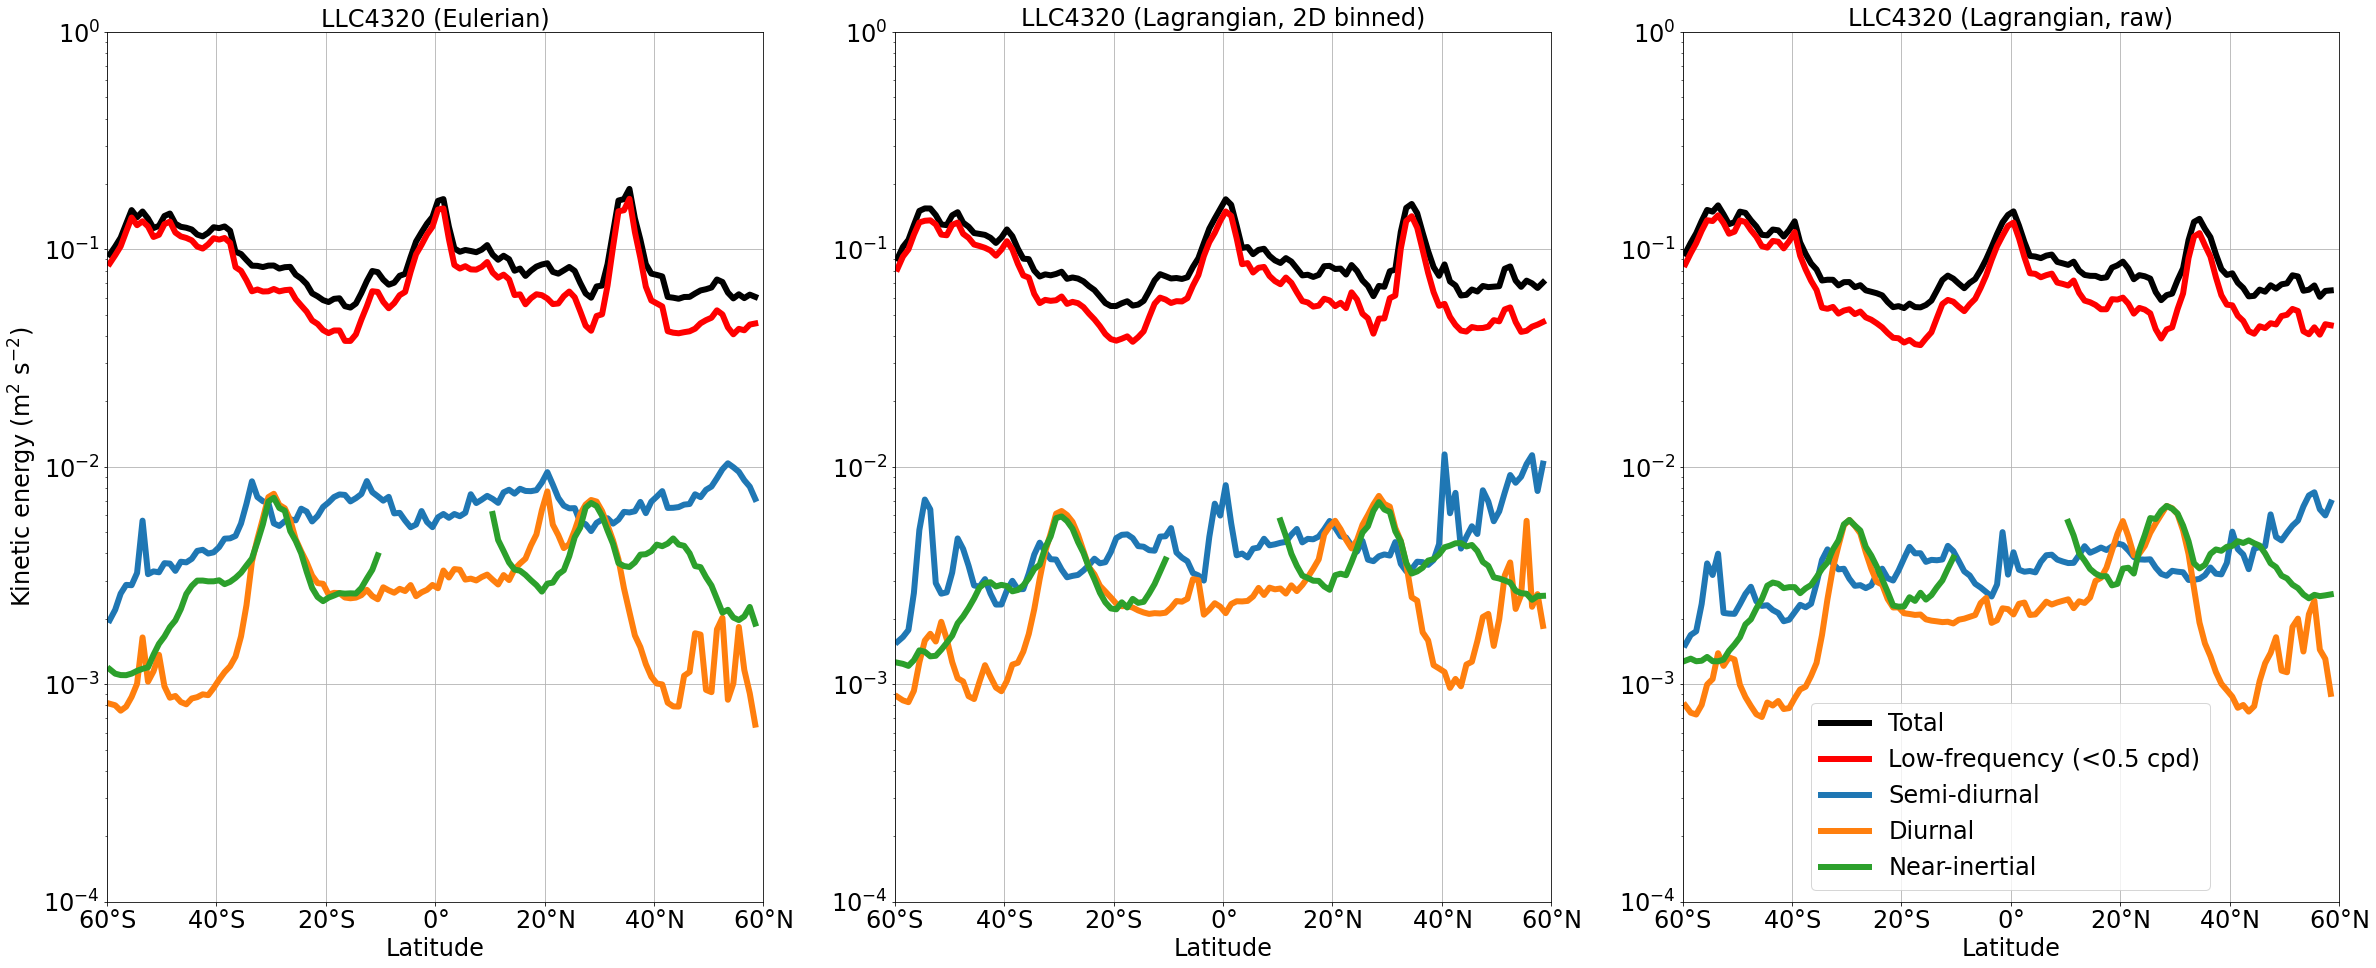

In [12]:
labels = ['Total', 'Low-frequency (<0.5 cpd)','High-frequency (>0.5 cpd)','Semi-diurnal', 'Diurnal', 'Near-inertial']
linewidth = 6
fontsize = 24

fig, ax = plt.subplots(figsize=(40,16))

ax = plt.subplot(131)
E_E.sel(frequency_band='total').mean('lon_bins').plot(color='black', label=labels[0], linewidth=linewidth) # total energy
E_E.sel(frequency_band='low').mean('lon_bins').plot(color='red', label=labels[1], linewidth=linewidth) # low energy
E_E.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot(label=labels[3], linewidth=linewidth) # energy around semi-diurnal frequencies
E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(label=labels[4], linewidth=linewidth) # energy around diurnal frequencies
E_E.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(label=labels[5], linewidth=linewidth) # energy around f
#ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e0])
# Label, size
ax.set_xlabel('Latitude',fontsize=fontsize)
ax.set_ylabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('LLC4320 (Eulerian)',fontsize=fontsize)
ax.set_ylabel('Kinetic energy (m$^2$ s$^{-2}$)',fontsize=fontsize)

ax = plt.subplot(132)
E_L.sel(frequency_band='total').mean('lon_bins').plot(color='black', label=labels[0], linewidth=linewidth) # total energy
E_L.sel(frequency_band='low').mean('lon_bins').plot(color='red', label=labels[1], linewidth=linewidth) # low energy
E_L.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot(label=labels[3], linewidth=linewidth) # energy around semi-diurnal frequencies
E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(label=labels[4], linewidth=linewidth) # energy around diurnal frequencies
E_L.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(label=labels[5], linewidth=linewidth) # energy around f
#ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e0])
# Label, size
ax.set_xlabel('Latitude',fontsize=fontsize)
ax.set_ylabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('LLC4320 (Lagrangian, 2D binned)',fontsize=fontsize)

ax = plt.subplot(133)
(E_Lagrangian*df).sum(dim='frequency').plot(color='black', label=labels[0], linewidth=linewidth) # total energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)<0.5) , other=0.)*df).sum(dim='frequency').plot(color='red', label=labels[1], linewidth=linewidth) # total energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.9) & (abs(E_Lagrangian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[3], linewidth=linewidth) # energy around semi-diurnal frequencies
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.9) & (abs(E_Lagrangian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[4], linewidth=linewidth) # energy around diurnal frequencies
(E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat_bins)>10).plot(label=labels[5], linewidth=linewidth) # energy around f
ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e0])
# Label, size
ax.set_xlabel('Latitude',fontsize=fontsize)
#ax.set_ylabel('Kinetic energy (m$^2$ s$^{-2}$)',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('LLC4320 (Lagrangian, raw)',fontsize=fontsize)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian.png')

In [9]:
E_L_interp = (E_Lagrangian.where((abs(E_Lagrangian.frequency)<12) , other=0.)*df).sum(dim='frequency').interp(lat_bins = ds_c.lat_bins)
E_L_interp

<xarray.DataArray (lat_bins: 61)>
dask.array<dask_aware_interpnd, shape=(61,), dtype=float64, chunksize=(61,), chunktype=numpy.ndarray>
Coordinates:
  * lat_bins  (lat_bins) float64 -60.0 -58.0 -56.0 -54.0 ... 54.0 56.0 58.0 60.0

In [10]:
E_E_weights_interp = E_E_weights.sel(frequency_band='total').interp(lat_bins = ds.lat_bins)
E_E_weights_interp

<xarray.DataArray (lat_bins: 119)>
dask.array<dask_aware_interpnd, shape=(119,), dtype=float64, chunksize=(119,), chunktype=numpy.ndarray>
Coordinates:
    frequency_band  <U5 'total'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5

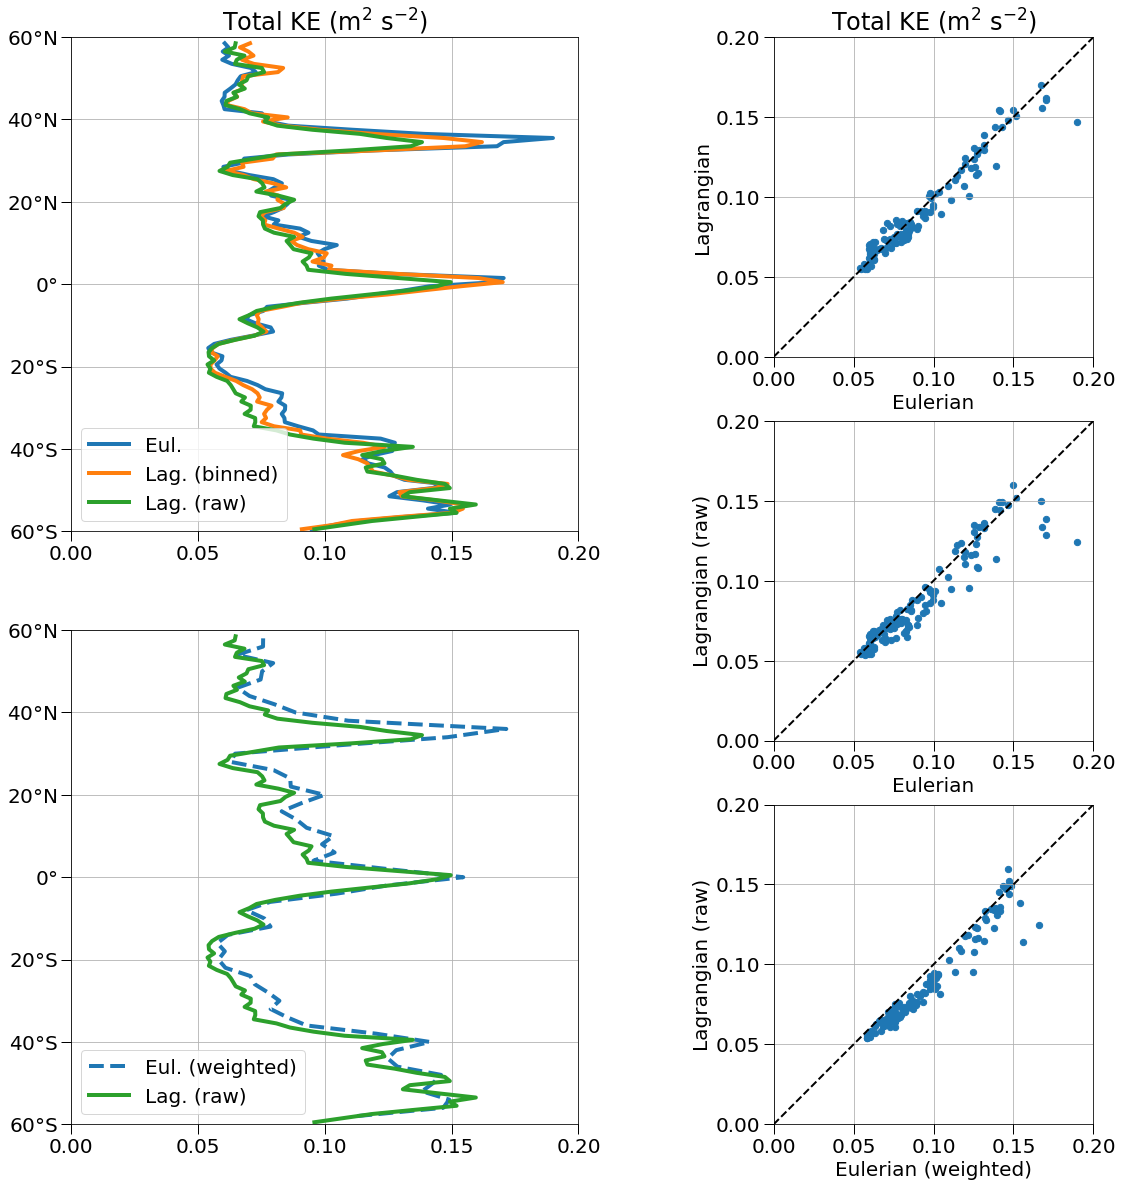

In [13]:
labels = ['Eulerian', 'Lagrangian','Lagrangian (raw)', 'Eulerian (weighted)']
labels = ['Eul.', 'Lag. (binned)','Lag. (raw)', 'Eul. (weighted)']
font_size = 20
upper_limit= 0.2
lims = (0, .3)
s_size = 40
fig, ax = plt.subplots(figsize=(20,20))

ax = plt.subplot(221)
E_E.sel(frequency_band='total').mean('lon_bins').plot(y='lat_bins', label=labels[0], linewidth=4) # total energy
E_L.sel(frequency_band='total').mean('lon_bins').plot(y='lat_bins', label=labels[1], linewidth=4) # total energy
(E_Lagrangian*df).sum(dim='frequency').plot(y='lat_bins', label=labels[2], linewidth=4,ls='-') # total energy
ax.legend(prop={'size': font_size}); ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.2])
ax.set_xticks([0,0.05,0.1,0.15,0.2])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Total KE (m$^2$ s$^{-2}$)',fontsize=font_size+4)
ax.legend(loc='lower left', prop={'size': font_size})
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(223)
E_E_weights.sel(frequency_band='total').plot(y='lat_bins', label=labels[3], linewidth=4,ls='--') 
#E_L.sel(frequency_band='total').mean('lon_bins').plot(y='lat_bins', label=labels[1], linewidth=4) # total energy
(E_Lagrangian*df).sum(dim='frequency').plot(y='lat_bins',color='tab:green', label=labels[2], linewidth=4,ls='-') # total energy
ax.legend(prop={'size': font_size}); ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.2])
ax.set_xticks([0., 0.05, 0.1, 0.15, 0.20])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.legend(loc='lower left', prop={'size': font_size})
ax.tick_params(direction='out', length=10, width=1)


ax = plt.subplot(322)
ax.scatter( E_E.sel(frequency_band='total').mean('lon_bins'), E_L.sel(frequency_band='total').mean('lon_bins'), s=s_size)
ax.set_aspect('equal', 'box')
ax.grid(); 
ax.set_xlim(0.,0.2); ax.set_ylim(0.,0.2)
ax.set_xticks([0,0.05,0.1,0.15,0.2])
ax.set_yticks([0,0.05,0.1,0.15,0.2])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Total KE (m$^2$ s$^{-2}$)',fontsize=font_size+4)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('Lagrangian',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(324)
ax.scatter( E_E.sel(frequency_band='total').mean('lon_bins'), (E_Lagrangian.where((abs(E_Lagrangian.frequency)<12) , other=0.)*df).sum(dim='frequency'), s=s_size)
ax.set_aspect('equal', 'box')
ax.grid(); 
ax.set_xlim(0.,0.2); ax.set_ylim(0.,0.2)
ax.set_xticks([0,0.05,0.1,0.15,0.2])
ax.set_yticks([0,0.05,0.1,0.15,0.2])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('Lagrangian (raw)',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

ax = plt.subplot(326)
ax.scatter( E_E_weights_interp, (E_Lagrangian.where((abs(E_Lagrangian.frequency)<12) , other=0.)*df).sum(dim='frequency'), s=s_size)
ax.set_aspect('equal', 'box')
ax.grid(); 
ax.set_xlim(0.,0.2); ax.set_ylim(0.,0.2)
ax.set_xticks([0,0.05,0.1,0.15,0.2])
ax.set_yticks([0,0.05,0.1,0.15,0.2])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian (weighted)',fontsize=font_size)
ax.set_ylabel('Lagrangian (raw)',fontsize=font_size)
ax.tick_params(direction='out', length=10, width=1)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Total_KE_comparison_lat_together.png')

_________
## Correlation R 

In [ ]:
E_Lagrangian.load()
E_E_weights_interp.load()
E_L.load()
E_E.load()

In [23]:
R = xr.corr(E_L.sel(frequency_band='total').mean('lon_bins'), E_E.sel(frequency_band='total').mean('lon_bins'), dim=['lat_bins'])
R.values

array(0.96977316)

In [25]:
R = xr.corr((E_Lagrangian*df).sum(dim='frequency'), E_E.sel(frequency_band='total').mean('lon_bins'), dim=['lat_bins'])
R.values

array(0.93750354)

In [28]:
R = xr.corr((E_Lagrangian*df).sum(dim='frequency'), E_E_weights_interp, dim=['lat_bins'])
R.values

array(0.96557743)

## R$^2$ and p value

In [22]:
p = xs.pearson_r_eff_p_value(E_L.sel(frequency_band='total').mean('lon_bins'), E_E.sel(frequency_band='total').mean('lon_bins'), dim=['lat_bins'],
                             skipna=True
                            )
p

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xskillscore/core/deterministic.py:473: UserWarning: ['lat_bins'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


<xarray.DataArray ()>
array(6.74870198e-05)
Coordinates:
    frequency_band  <U5 'total'

In [24]:
r = xs.pearson_r(E_L.sel(frequency_band='total').mean('lon_bins'), E_E.sel(frequency_band='total').mean('lon_bins'), dim=['lat_bins'],
                 skipna=True
                )
r**2

<xarray.DataArray ()>
array(0.94045998)
Coordinates:
    frequency_band  <U5 'total'

In [26]:
p = xs.pearson_r_eff_p_value((E_Lagrangian*df).sum(dim='frequency'), E_E.sel(frequency_band='total').mean('lon_bins'), dim=['lat_bins'],
                             skipna=True
                            )
p

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xskillscore/core/deterministic.py:473: UserWarning: ['lat_bins'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


<xarray.DataArray ()>
array(0.00181299)
Coordinates:
    frequency_band  <U5 'total'

In [27]:
r = xs.pearson_r((E_Lagrangian*df).sum(dim='frequency'), E_E.sel(frequency_band='total').mean('lon_bins'), dim=['lat_bins'],
                 skipna=True
                )
r**2

<xarray.DataArray ()>
array(0.87891289)
Coordinates:
    frequency_band  <U5 'total'

In [29]:
p = xs.pearson_r_eff_p_value((E_Lagrangian*df).sum(dim='frequency'), E_E_weights_interp, dim=['lat_bins'],
                             skipna=True
                            )
p

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xskillscore/core/deterministic.py:473: UserWarning: ['lat_bins'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


<xarray.DataArray ()>
array(0.00762682)
Coordinates:
    frequency_band  <U5 'total'

In [30]:
r = xs.pearson_r((E_Lagrangian*df).sum(dim='frequency'), E_E_weights_interp, dim=['lat_bins'],
                 skipna=True
                )
r**2

<xarray.DataArray ()>
array(0.93233977)
Coordinates:
    frequency_band  <U5 'total'

## Slope

In [11]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [15]:
slopes = xr.apply_ufunc(linear_trend,
                        E_L.sel(frequency_band='total').mean('lon_bins'),
                        E_E.sel(frequency_band='total').mean('lon_bins'),
                        vectorize=True,
                        input_core_dims=[['lat_bins'], ['lat_bins']],# reduce along 'plev'
                        )
slopes

<xarray.DataArray ()>
array(1.02961781)
Coordinates:
    frequency_band  <U5 'total'

In [17]:
slopes = xr.apply_ufunc(linear_trend,
                        (E_Lagrangian*df).sum(dim='frequency'),
                        E_E.sel(frequency_band='total').mean('lon_bins'),
                        vectorize=True,
                        input_core_dims=[['lat_bins'], ['lat_bins']],# reduce along 'plev'
                        )
slopes

<xarray.DataArray ()>
array(1.02528732)
Coordinates:
    frequency_band  <U5 'total'

In [18]:
slopes = xr.apply_ufunc(linear_trend,
                        (E_Lagrangian*df).sum(dim='frequency'),
                        E_E_weights_interp,
                        vectorize=True,
                        input_core_dims=[['lat_bins'], ['lat_bins']],# reduce along 'plev'
                        )
slopes

<xarray.DataArray ()>
array(nan)
Coordinates:
    frequency_band  <U5 'total'

## RMSE

In [14]:
rmse = np.sqrt(((E_L.sel(frequency_band='total').mean('lon_bins')-E_E.sel(frequency_band='total').mean('lon_bins'))**2).sum('lat_bins')/119)
rmse.values

array(0.00768849)

In [15]:
rmse = np.sqrt((((E_Lagrangian*df).sum(dim='frequency')-E_E.sel(frequency_band='total').mean('lon_bins'))**2).sum('lat_bins')/119)
rmse.values

array(0.01173532)

In [16]:
rmse = np.sqrt((((E_Lagrangian*df).sum(dim='frequency')-E_E_weights_interp)**2).sum('lat_bins')/119)
rmse.values

array(0.01069819)

## Close cluster

In [15]:
cluster.close()